### Chatbot with multiple tools

In [15]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['GOOGLE_API_KEY'] = os.getenv('GOOGLE_API_KEY')
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')

google_api = os.environ['GOOGLE_API_KEY']


In [3]:
from langchain_community.tools import ArxivQueryRun
from langchain_community.utilities import ArxivAPIWrapper

In [4]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=3, doc_content_chars_max=700)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [5]:
arxiv.invoke("Agentic AI")

"Published: 2025-07-02\nTitle: AI Agents and Agentic AI-Navigating a Plethora of Concepts for Future Manufacturing\nAuthors: Yinwang Ren, Yangyang Liu, Tang Ji, Xun Xu\nSummary: AI agents are autonomous systems designed to perceive, reason, and act within\ndynamic environments. With the rapid advancements in generative AI (GenAI),\nlarge language models (LLMs) and multimodal large language models (MLLMs) have\nsignificantly improved AI agents' capabilities in semantic comprehension,\ncomplex reasoning, and autonomous decision-making. At the same time, the rise\nof Agentic AI highlights adaptability and goal-directed autonomy in dynamic and\ncomplex environments. LLMs-based AI Agents (LLM-Agents), MLLM"

In [8]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()

tavily.invoke("Who is 2nd highest run getter in test cricket")

[{'title': 'Joe Root: England batting star becomes second highest ... - Sky Sports',
  'url': 'https://www.skysports.com/cricket/news/12123/13401678/joe-root-england-batting-star-becomes-second-highest-all-time-test-run-scorer-behind-only-sachin-tendulkar',
  'content': "Joe Root now sits second on the list of all-time Test run-scorers - and there is a more than decent chance he ends up top of the pile before his career is over.\n\nThe England batter pushed past Rahul Dravid, Jacques Kallis and Ricky Ponting while scoring 150 - his 38th Test ton - on day three of the fourth Test against India at Emirates Old Trafford and it is now only Sachin Tendulkar keeping him off the summit. [...] Sky Sports\n\nCricket\n\n#### Internationals\n\n#### Domestic\n\n#### Indian Premier League\n\n#### Domestic Leagues\n\n#### Internationals\n\n# Joe Root: England batting star becomes second highest all-time Test run-scorer behind only Sachin Tendulkar [...] Joe Root moves past Rahul Dravid, Jacques Kall

In [9]:
tools = [arxiv, tavily]

In [ ]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.1-8b-instant")
llm_with_tools = llm.bind_tools(tools)


In [38]:

from pprint import pprint
from langchain_core.messages import HumanMessage, AnyMessage

llm_with_tools.invoke([HumanMessage(content="Who 2nd Highest run getter in ODI cricket")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '5wk97maaw', 'function': {'arguments': '{"query":"2nd Highest run getter in ODI cricket"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 438, 'total_tokens': 464, 'completion_time': 0.036492222, 'prompt_time': 0.033523099, 'queue_time': 0.051188251000000004, 'total_time': 0.070015321}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4991c37f-aa0a-4855-bac6-de7e7a231bef-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '2nd Highest run getter in ODI cricket'}, 'id': '5wk97maaw', 'type': 'tool_call'}], usage_metadata={'input_tokens': 438, 'output_tokens': 26, 'total_tokens': 464})

In [20]:
#### Chatbot with langgraph

In [30]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from typing import Annotated

In [31]:
#state schema

class State(TypedDict):
    messages = Annotated[list[AnyMessage], add_messages]
    

In [35]:
def tool_calling_llm(state:State):
    return{"messages": llm_with_tools.invoke(state['messages'])}

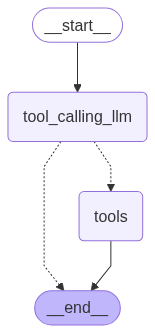

In [37]:
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    #if latest msg form assistance is tool call -> tools_conditions routes to tool
    # if latest msg from assistance is not tool call -> tools condtion routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))